In [25]:
import numpy as np
import argparse
import pickle

import torch
from torch import nn

import umap
import umap.plot
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

from utils.models import FashionMLP, FashionCNN, FashionSVM, LeastSquaresClassifier
from utils.dataset import IN_FEATURES, NUM_CLASSES, get_dataset
from utils.utils import train, valid_epoch

In [26]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [27]:
stop_layer = 'fc2'

In [51]:
torch.manual_seed(1234)

# select device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load dataset
train_set, test_set = get_dataset()
train_loader = DataLoader(train_set, batch_size=2048, shuffle=True)

# load model
model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load('models/best_model_cnn.pth'))

getattr(model,stop_layer).register_forward_hook(get_activation(stop_layer))

output_train_layer2 = []
train_labels = []
model.eval()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    train_labels.append(labels)
    output_train_layer2.append(activation[stop_layer].flatten(1))
    
# concatenate output and labels
output_train_layer2 = torch.cat(output_train_layer2)
train_labels = torch.cat(train_labels)


Train/Test: 86%/14%


In [29]:
images, labels = next(iter(train_loader))

In [30]:
images, labels = images.to(device), labels.to(device)
outputs = model(images)
labels = labels.detach().numpy()
out = activation[stop_layer].flatten(1).detach().numpy()

In [40]:
classes = np.array(("T-shirt/Top", "Trouser", "Pullover", "Dress",
 "Coat",  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"))

In [47]:
labels_df = pd.DataFrame(labels, columns=['labels'])
labels_df = labels_df.assign(labels = lambda x:classes[list(x['labels'])])
features_df = pd.DataFrame(out)

In [48]:
df = pd.concat([labels_df, features_df], axis='columns')

In [49]:
df

,labels,0,1,2,3,4,5,6,7,8,9
0,Bag,0.0,47.876362,0.0,0.0,0.000000,0.000000,0.0,0.531470,0.000000,6.154346
1,Sneaker,0.0,1.107349,0.0,0.0,0.000000,22.126945,0.0,1.869746,0.208189,26.884457
2,T-shirt/Top,0.0,17.835758,0.0,0.0,0.000000,24.668385,0.0,15.660872,10.441818,0.000000
3,Ankle Boot,0.0,20.965469,0.0,0.0,0.000000,0.000000,0.0,5.937665,0.000000,3.815810
4,Pullover,0.0,8.124088,0.0,0.0,36.400238,11.727009,0.0,0.000000,40.743996,0.476322
...,...,...,...,...,...,...,...,...,...,...,...
2043,Sandal,0.0,0.000000,0.0,0.0,0.000000,4.552824,0.0,33.489983,8.157007,12.729321
2044,Bag,0.0,2.627685,0.0,0.0,0.000000,3.695044,0.0,17.179930,4.804338,10.861893
2045,Sandal,0.0,0.000000,0.0,0.0,0.000000,16.049900,0.0,7.374111,0.000000,24.516026
2046,Trouser,0.0,0.000000,0.0,0.0,0.000000,12.395323,0.0,26.177353,2.855358,14.417826


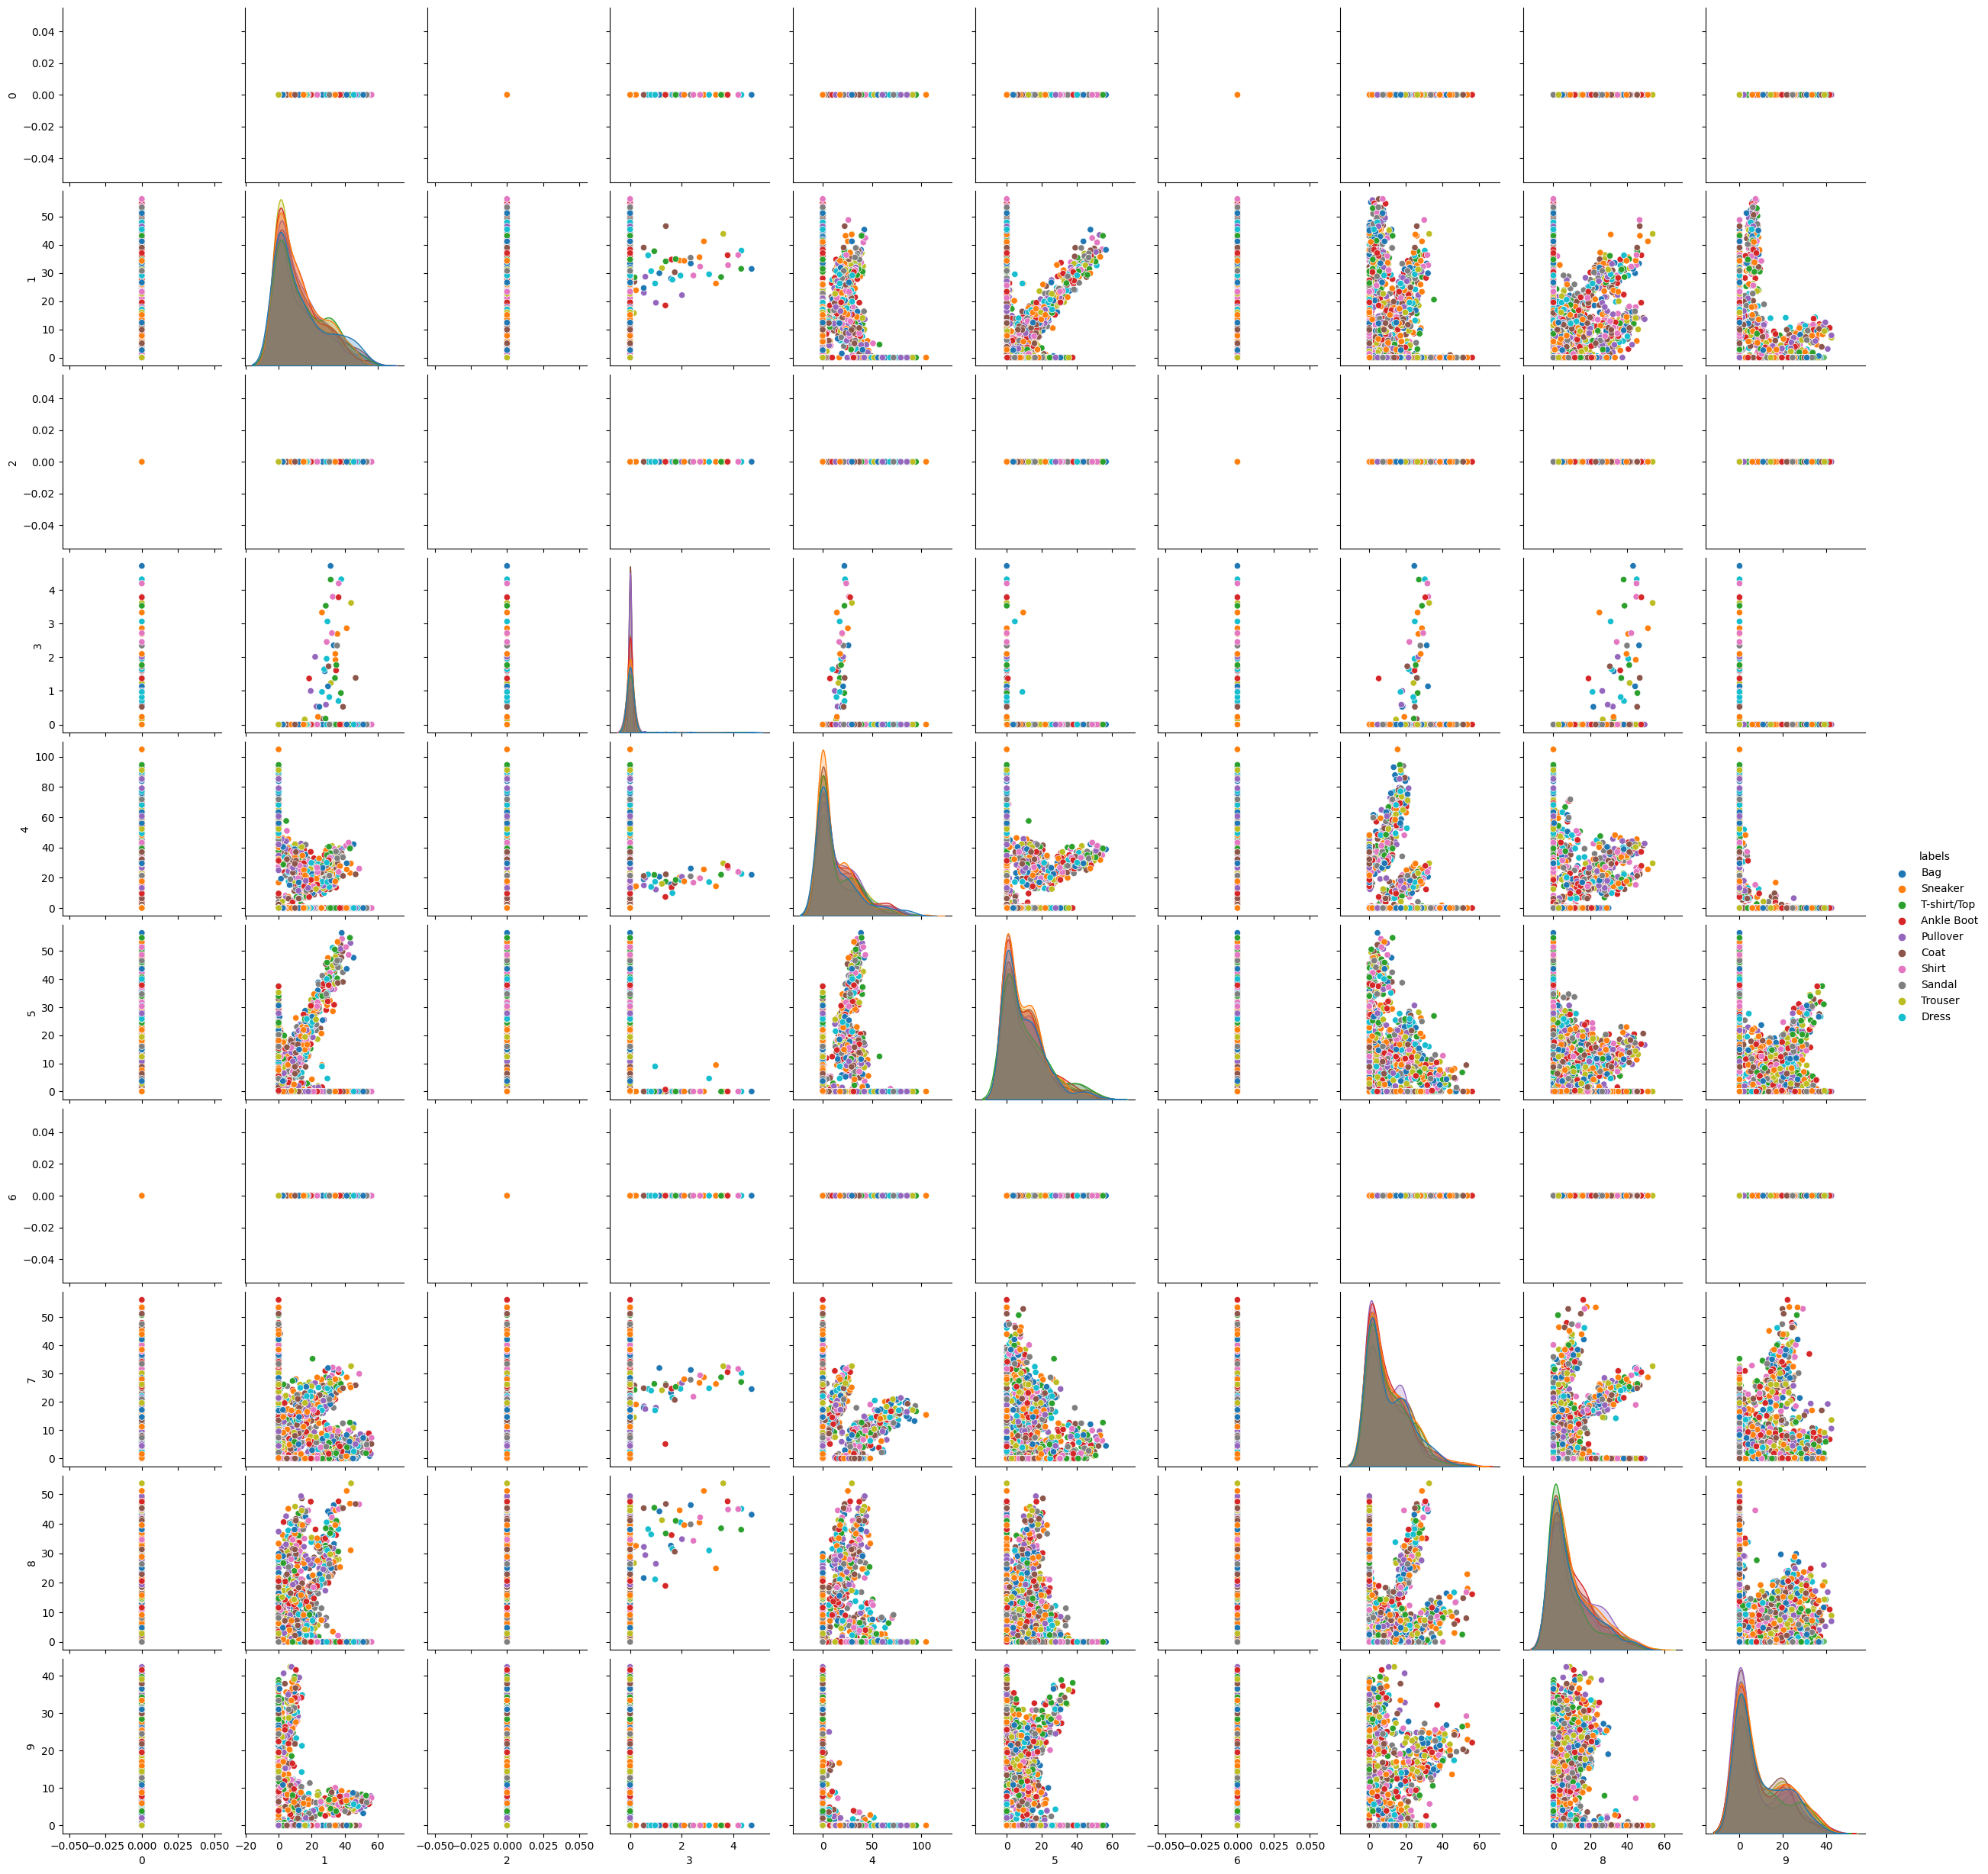

In [52]:
plot = sns.pairplot(df, hue="labels")

In [53]:
plot.figure.savefig('output/cnn_output_fc2(2).png')

In [54]:
mapper = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=10)
mapper = mapper.fit(output_train_layer2)

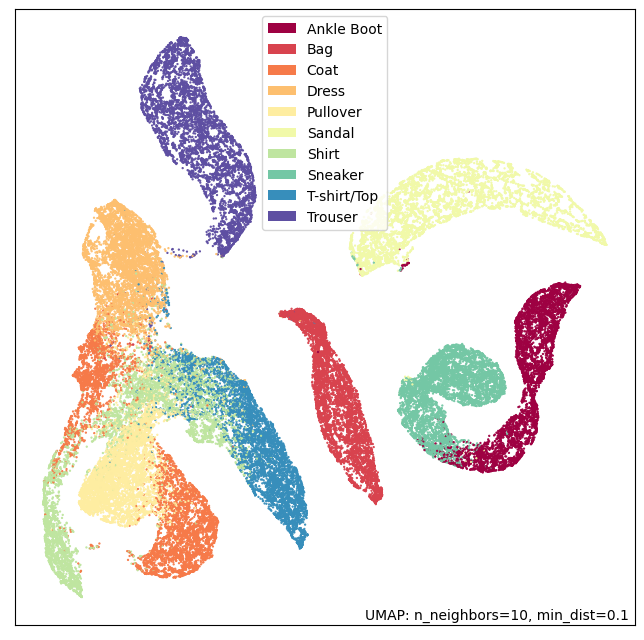

In [55]:
plot = umap.plot.points(mapper, labels=classes[train_labels])

In [56]:
plot.figure.savefig('output/umap_output_fc2(2).png')

In [57]:
stop_layer = 'layer2'

In [58]:
getattr(model,stop_layer).register_forward_hook(get_activation(stop_layer))

output_train_layer2 = []
train_labels = []
model.eval()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    train_labels.append(labels)
    output_train_layer2.append(activation[stop_layer].flatten(1))
    
# concatenate output and labels
output_train_layer2 = torch.cat(output_train_layer2)
train_labels = torch.cat(train_labels)

In [59]:
mapper = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=10)
mapper = mapper.fit(output_train_layer2)

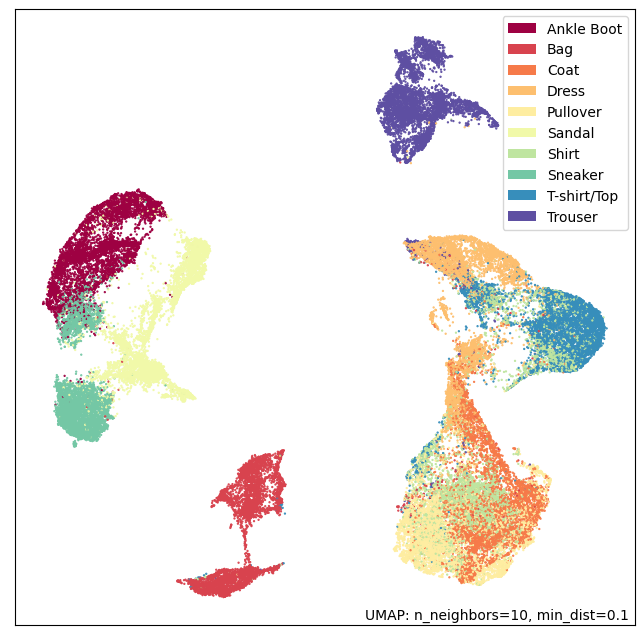

In [60]:
plot = umap.plot.points(mapper, labels=classes[train_labels])

In [61]:
plot.figure.savefig('output/umap_output_layer2(2).png')

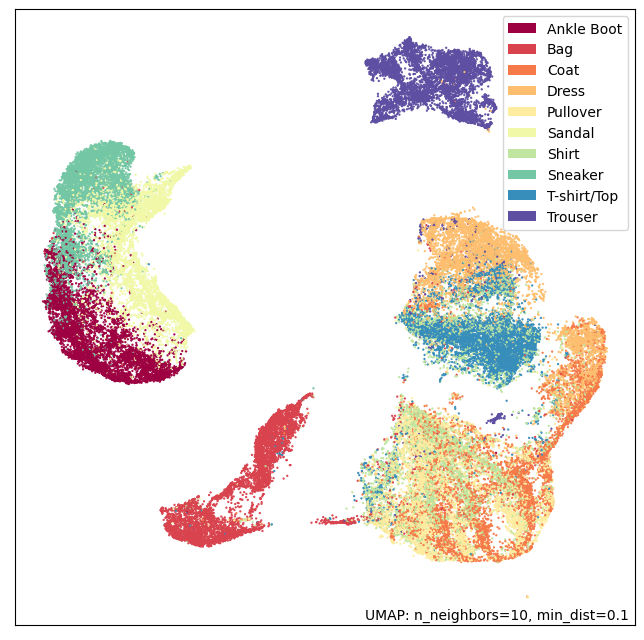

In [62]:
mapper = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=10)
mapper = mapper.fit(train_set.data.flatten(1))
plot = umap.plot.points(mapper, labels=classes[train_set.targets])
plot.figure.savefig('output/umap_initial_layer.png')